In [15]:
from introduction_ia_terminale.preprocessing.fake_news_preprocessor import FakeNewsPreprocessor
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import RobertaTokenizer, RobertaModel

from torch.utils.data import Dataset
import torch

from typing import Tuple

In [2]:
preprocessor = FakeNewsPreprocessor(root_path='../../data/fake_news/')
df = preprocessor.dataframe

# Répartition des sujets fake news

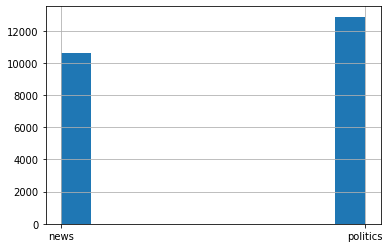

In [3]:
df[df['is_fake'] == 1]['subject'].hist();

Les fakes news semblents bien balancés. Maintenant regardons dans l'ensemble des news.

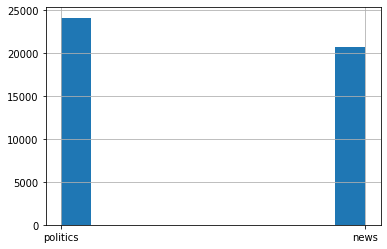

In [4]:
df['subject'].hist();

Toujours aussi bien balancé !

# Répartition de la longueur des articles

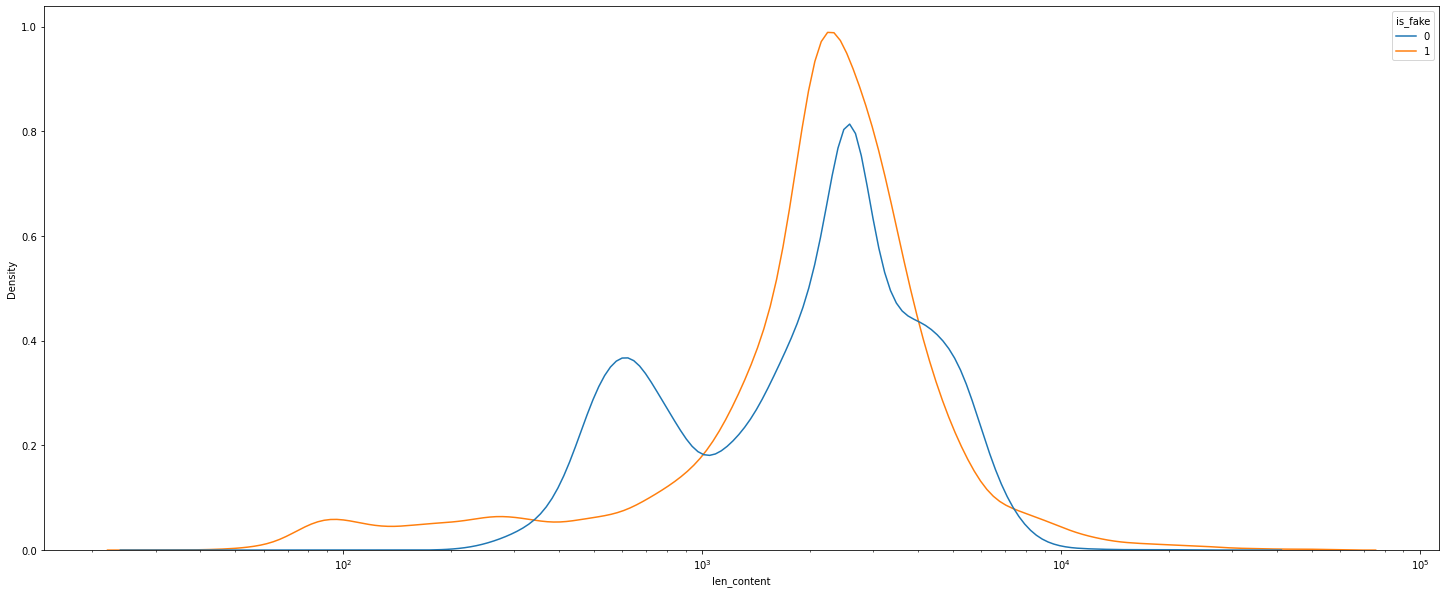

In [5]:
df['len_content'] = df['content'].apply(lambda content: len(content))

fig = plt.figure(figsize=(25, 10))
sns.kdeplot(data=df, x='len_content', log_scale=True, hue='is_fake');

La répartition en longueur de texte est également bien répartie ! On va pouvoir réfléchir à la stratégie de tokénization pour pouvoir classifier les articles, selon le contenu et le type d'article !

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

In [7]:
# tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt')

Plusieurs possibilités sont envisageables, la première serait de récupérer le code de l'encodeur BERT et d'utiliser uniquement la sortie de la dernière couche d'encodeur et moyenner la sortie de l'encodeur pour tous les chunks de texte. Sinon, on ne considère que la première partie du contenu (les 512 premiers tokens), puis that's it !

On peut commencer par la deuxième solution qui est plus simple à implémenter.

Pour construire notre Dataset et notre DataLoader, nous avons besoin de créer les tenseurs puis de les affecter directement au dataset, pré-tokénizé.

In [10]:
contents = df['content'].tolist()
targets = df['is_fake'].tolist()

tokenized_contents = tokenizer(contents, truncation=True, padding=True, return_tensors='pt')

In [12]:
tokenized_contents.keys()

dict_keys(['input_ids', 'attention_mask'])

In [16]:
class FakeNewsDataset(Dataset):
    def __init__(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, targets: torch.Tensor, **torch_dataset) -> None:
        super(FakeNewsDataset, self).__init__(**torch_dataset)
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.targets = targets

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.input_ids[idx], self.attention_mask[idx], self.targets[idx]

    def __len__(self) -> int:
        return len(self.input_ids)

In [17]:
dataset = FakeNewsDataset(tokenized_contents['input_ids'], tokenized_contents['attention_mask'], torch.tensor(targets))

In [18]:
dataset[0]

(tensor([    0,  1620,   121,     4,   104,     4,  1229,  1032, 26165,     6,
          1858, 11113,    49,  2358,  8543,     4,   305,  8684,    36,  1251,
            43,   111,    20,   471,     9,    10,  3354,  1172, 18666,    11,
             5,   121,     4,   104,     4,  1148,     6,    54,  2763,    42,
           353,    13,    10,  1307,  2919,     9,     5,   632,  1126,     7,
           582,    13,   629,  2599,     6,   373,  1003,    10,    44,    48,
           506, 26104,  3354,    17,    46,    15,   395,     8,  2966,  1229,
         20219,    11,   199,     4,    96,  2396,    19,    10,  4406, 27475,
           223,   169,   566,  1858,     6,   121,     4,   104,     4, 10308,
          1190, 16438,     6,  2686,    15,  3710,    17,    27,    44,    48,
         34892,     5,  5857,     6,    17,    46,  4855,    10,   543,   516,
            15,   752,  1408,     6,    61,  2648,    32,  5378,  7575,     7,
           109,  2168,    81,    11,   644,     4,  